Training class counts: Counter({'glass': 999, 'paper': 727, 'cardboard': 618, 'plastic': 591, 'trash': 525, 'metal': 525})
Test class counts: Counter({'glass': 428, 'paper': 311, 'cardboard': 264, 'plastic': 252, 'metal': 225, 'trash': 224})


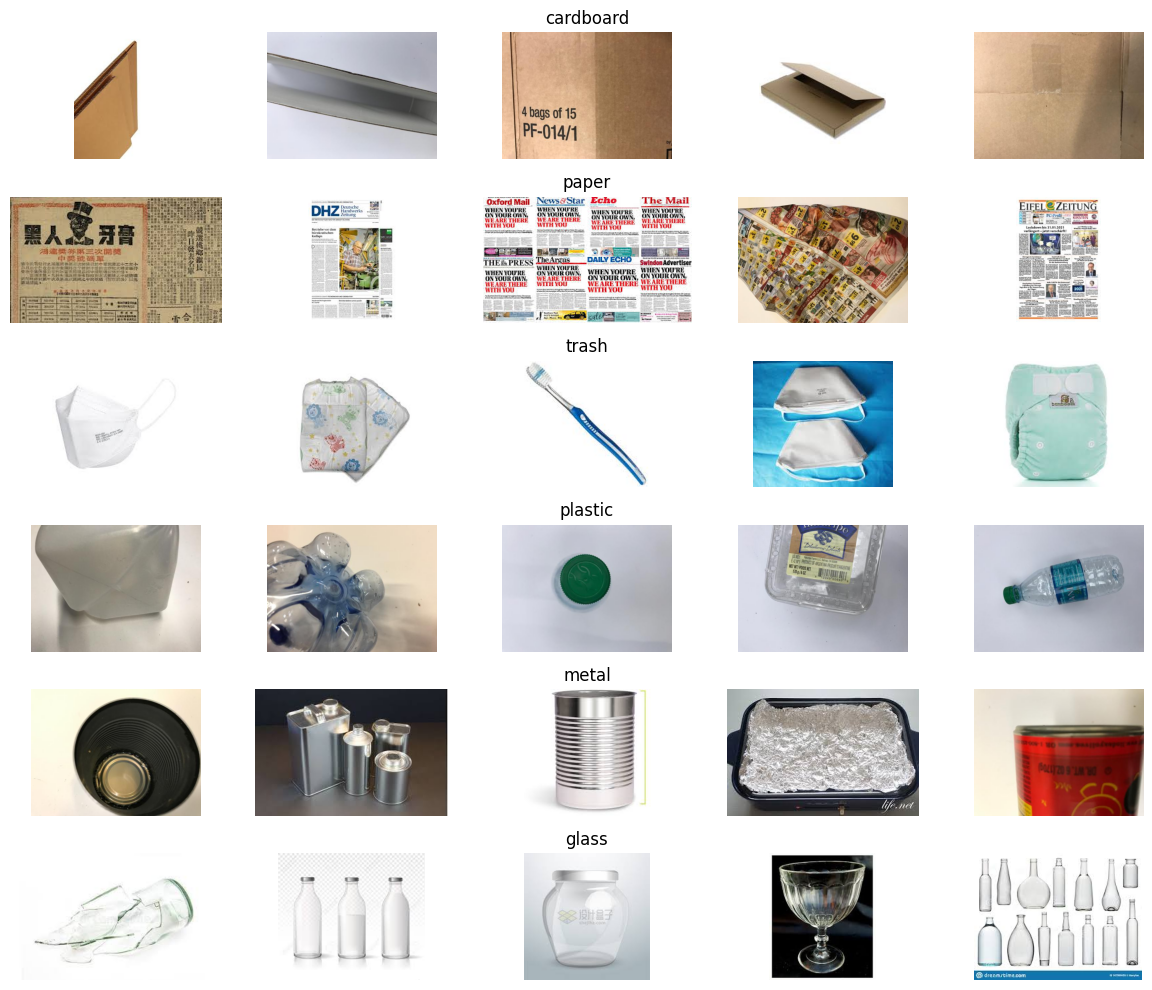

Image width range: 51 - 512
Image height range: 100 - 400


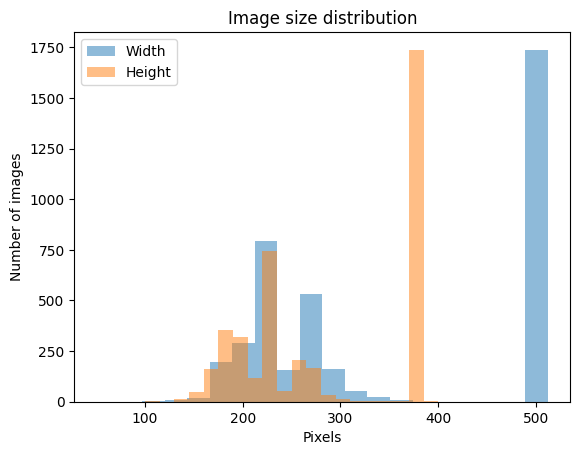

Color channels distribution: Counter({'RGB': 3973, 'P': 12})


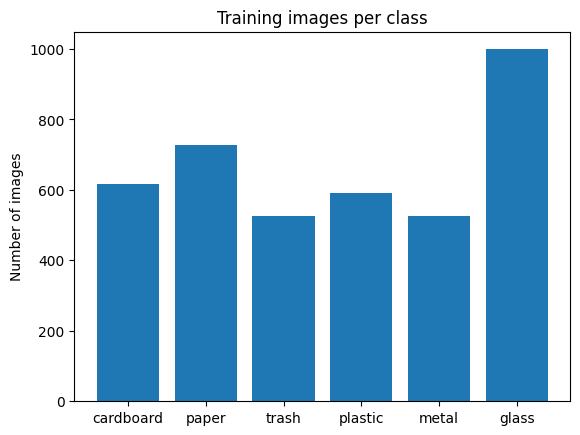

In [2]:
# EDA

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
from pathlib import Path
from PIL import Image
import random
import numpy as np
from dotenv import load_dotenv
import os

load_dotenv()

data_dir = Path(os.getenv("PROJECT_DIR")) / os.getenv("DATA_DIR")
train_dir = data_dir / "train"
test_dir = data_dir / "test"

# Helper function to extract class from filename
def get_class(file_path):
    return file_path.name.split("_")[1]  # e.g., 'train_cardboard_014.jpg' -> 'cardboard'

# ----------------------------
# 1️⃣ Class counts
# ----------------------------
train_files = list(train_dir.glob("*.jpg"))
train_classes = [get_class(f) for f in train_files]
train_counts = Counter(train_classes)
print("Training class counts:", train_counts)

test_files = list(test_dir.glob("*.jpg"))
test_classes = [get_class(f) for f in test_files]
test_counts = Counter(test_classes)
print("Test class counts:", test_counts)

# ----------------------------
# 2️⃣ Sample images per class
# ----------------------------
classes = list(train_counts.keys())
fig, axes = plt.subplots(len(classes), 5, figsize=(12, 10))
for i, cls in enumerate(classes):
    cls_files = [f for f in train_files if get_class(f) == cls]
    for j, img_path in enumerate(random.sample(cls_files, min(5, len(cls_files)))):
        ax = axes[i, j]
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis("off")
        if j == 2:
            ax.set_title(cls)
plt.tight_layout()
plt.show()

# ----------------------------
# 3️⃣ Image sizes
# ----------------------------
sizes = [Image.open(f).size for f in train_files]
widths, heights = zip(*sizes)
print(f"Image width range: {min(widths)} - {max(widths)}")
print(f"Image height range: {min(heights)} - {max(heights)}")

plt.hist(widths, bins=20, alpha=0.5, label="Width")
plt.hist(heights, bins=20, alpha=0.5, label="Height")
plt.xlabel("Pixels")
plt.ylabel("Number of images")
plt.title("Image size distribution")
plt.legend()
plt.show()

# ----------------------------
# 4️⃣ Color channels check
# ----------------------------
modes = [Image.open(f).mode for f in train_files]
mode_counts = Counter(modes)
print("Color channels distribution:", mode_counts)

# ----------------------------
# 5️⃣ Class distribution bar chart
# ----------------------------
plt.bar(train_counts.keys(), train_counts.values())
plt.title("Training images per class")
plt.ylabel("Number of images")
plt.show()


In [ ]:
from collections import Counter
from xml.parsers.expat import model

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, models

from config import Config
from data_manager import DataManager
from material_dataset import MaterialDataset
from train_model import TrainModel  # your class

from logger import setup_logging
import logging

def main():

    # Initialize config
    cfg = Config()

    # Setup logging
    setup_logging(level=cfg.log_level, log_file=cfg.log_file)
    logger = logging.getLogger("main")

    # Check GPU availability
    def check_gpu():
        logger.info("CUDA: %s", torch.cuda.is_available())
        if torch.cuda.is_available():
            logger.info("GPU: %s", torch.cuda.get_device_name(0))

    check_gpu()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Extract dataset
    data_manager = DataManager()
    data_manager.extract_dataset()

    # Transforms
    transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.75, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(12),
        transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.15, hue=0.05),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.2),
        transforms.RandomGrayscale(p=0.05),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.2)),
        transforms.ToTensor(),
        transforms.Normalize(cfg.imagenet_mean, cfg.imagenet_std),
        transforms.RandomErasing(p=0.15),
    ])

    transform_test = transforms.Compose([
        transforms.Resize((256, 256)),  # <-- fixed H,W
        transforms.ToTensor(),
        transforms.Normalize(cfg.imagenet_mean, cfg.imagenet_std),
    ])

    # Files / labels
    train_files = data_manager.get_train_images_list()
    test_files  = data_manager.get_test_images_list()

    classes = data_manager.get_classes_list()
    class_to_idx = data_manager.get_class_index_map()

    train_labels = [class_to_idx[data_manager.get_class_from_filename(p)] for p in train_files]
    test_labels  = [class_to_idx[data_manager.get_class_from_filename(p)] for p in test_files]

    # Datasets
    train_dataset = MaterialDataset(
        files=train_files,
        transform=transform_train,
        classes=classes,
        class_to_idx=class_to_idx,
        labels=train_labels
    )
    test_dataset = MaterialDataset(
        files=test_files,
        transform=transform_test,
        classes=classes,
        class_to_idx=class_to_idx,
        labels=test_labels
    )

    # DataLoaders (good defaults)
    num_workers = getattr(cfg, "num_workers", 4)
    pin_memory = (device.type == "cuda")

    train_loader = DataLoader(
        train_dataset,
        batch_size=cfg.batch_size_train,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=cfg.batch_size_test,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    logger.info("Train images: %d | Test images: %d", len(train_dataset), len(test_dataset))
    logger.info("Train batches/epoch: %d", len(train_loader))
    logger.info("Classes: %s", train_dataset.classes)

    # Model
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    num_classes = len(train_dataset.classes)
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features, num_classes),
    )

    nn.init.kaiming_normal_(model.fc[1].weight)
    nn.init.zeros_(model.fc[1].bias)


    # Class weights
    counts = Counter(train_labels)
    weights = [1.0 / max(1, counts.get(i, 0)) for i in range(num_classes)]
    class_weights = torch.tensor(weights, dtype=torch.float, device=device)

    # Trainer
    trainer = TrainModel(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        device=device,
        cfg=cfg
    )

    bests = {}
    for stage in cfg.stages:
        stage_name = stage["name"]

        criterion = nn.CrossEntropyLoss(
            weight=class_weights if stage["use_class_weights"] else None,
            label_smoothing=stage["label_smoothing"],
        )

        bests[stage_name] = trainer.train_stage(
            stage_name=stage_name,
            epochs=stage["epochs"],
            lr_max=stage["lr_max"],
            wd=stage["wd"],
            criterion=criterion,
        )

    logger.info("Done. Bests: %s", bests)

    logger.info("Running final best model evals (fast flip TTA)...")

    trainer.load_model("../models/polish_best_model.pth")
    acc_flip_tta = trainer.evaluate_flip_tta(ema=None)

    trainer.load_model("../models/polish_with_ema_best_model.pth")
    acc_flip_tta = trainer.evaluate_flip_tta(ema=None)
    
    logger.info("Final flip TTA acc: %.4f", acc_flip_tta)

if __name__ == "__main__":
    main()


[21:32:07] [INFO] main: CUDA: True
[21:32:07] [INFO] main: GPU: NVIDIA GeForce RTX 3060 Ti
[21:32:07] [INFO] DataManager: Data directory set to: C:\Users\jackb\source\repos\Automated_Material_Recognition\data
[21:32:07] [INFO] main: Train images: 3979 | Test images: 1704
[21:32:07] [INFO] main: Train batches/epoch: 63
[21:32:07] [INFO] main: Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
[21:32:07] [INFO] TrainModel: Starting stage 'head' (5 epochs)
c:\Users\jackb\source\repos\Automated_Material_Recognition\src\train_model.py:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.amp_enabled):
c:\Users\jackb\source\repos\Automated_Material_Recognition\src\train_model.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.amp_enable

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, models
from collections import Counter

from config import Config
from data_manager import DataManager
from material_dataset import MaterialDataset
from train_model import TrainModel

# -----------------------------
# 0) Device + config
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfg = Config()

# -----------------------------
# 1) Load dataset file lists + class mapping (same as training)
# -----------------------------
data_manager = DataManager()
data_manager.extract_dataset()

test_files = data_manager.get_test_images_list()
classes = data_manager.get_classes_list()
class_to_idx = data_manager.get_class_index_map()
test_labels = [class_to_idx[data_manager.get_class_from_filename(p)] for p in test_files]

# -----------------------------
# 2) Build a TTA-friendly test transform (NO CenterCrop)
# -----------------------------
transform_test_tta = transforms.Compose([
    transforms.Resize((256, 256)),  # <-- fixed H,W
    transforms.ToTensor(),
    transforms.Normalize(cfg.imagenet_mean, cfg.imagenet_std),
])

test_dataset_tta = MaterialDataset(
    files=test_files,
    transform=transform_test_tta,
    classes=classes,
    class_to_idx=class_to_idx,
    labels=test_labels
)

test_loader_tta = DataLoader(
    test_dataset_tta,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)

# -----------------------------
# 3) Rebuild the model architecture (must match training)
# -----------------------------
num_classes = len(classes)
model = models.resnet50(weights=None)  # weights don't matter when loading your trained weights
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features, num_classes)
)
model = model.to(device)

# -----------------------------
# 4) Load checkpoint weights
# -----------------------------
CKPT_PATH = "../models/archive/best_polish_9712.pt"  # <-- change this
ckpt = torch.load(CKPT_PATH, map_location=device)

# If you saved {"model": state_dict, ...}
state_dict = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
model.load_state_dict(state_dict)

# -----------------------------
# 5) Evaluate using your trainer's flip TTA
# -----------------------------
trainer = TrainModel(model=model, train_loader=None, test_loader=test_loader_tta, device=device, cfg=cfg)

acc_flip_tta = trainer.evaluate_flip_tta()

print(f"Flip TTA acc: {acc_flip_tta:.4f}")

[15:18:23] [INFO] DataManager: Data directory set to: /home/jbiggs512/CODESPACE/Automated_Material_Recognition/data
[15:18:23] [INFO] DataManager: Unzipping dataset from /home/jbiggs512/CODESPACE/Automated_Material_Recognition/data/AI_Portfolio_Dataset.zip
[15:18:24] [WARNING] DataManager: Destination /home/jbiggs512/CODESPACE/Automated_Material_Recognition/data/train already exists. It will be overwritten.
[15:18:24] [INFO] DataManager: Moving /home/jbiggs512/CODESPACE/Automated_Material_Recognition/data/dataset/train to /home/jbiggs512/CODESPACE/Automated_Material_Recognition/data/train
[15:18:24] [WARNING] DataManager: Destination /home/jbiggs512/CODESPACE/Automated_Material_Recognition/data/test already exists. It will be overwritten.
[15:18:24] [INFO] DataManager: Moving /home/jbiggs512/CODESPACE/Automated_Material_Recognition/data/dataset/test to /home/jbiggs512/CODESPACE/Automated_Material_Recognition/data/test
[15:18:24] [INFO] DataManager: Removing temporary dataset directory 

Flip TTA acc: 0.9712


Device: cuda


Destination C:\Users\jackb\source\repos\Automated_Material_Recognition\data\train already exists. It will be overwritten.
Destination C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test already exists. It will be overwritten.


Test samples: 1704
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


C:\Users\jackb\AppData\Local\Temp\ipykernel_23048\2978057953.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CKPT_PATH, map_location=device)


Loaded: ../models/polish_best_model.pth
Test accuracy: 0.9624

Per-class accuracy:
     cardboard: 0.9773  (n=264)
         glass: 0.9836  (n=428)
         metal: 0.9600  (n=225)
         paper: 0.9839  (n=311)
       plastic: 0.9127  (n=252)
         trash: 0.9330  (n=224)


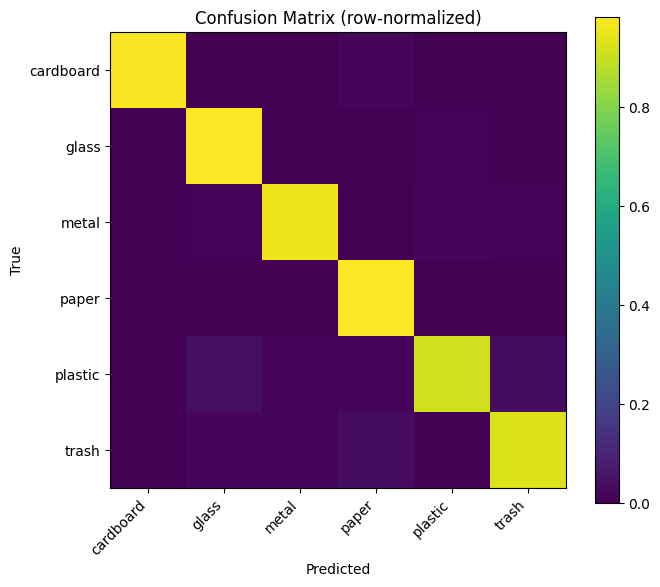


Wrong predictions: 64/1704 (3.76%)

Top confusions (true -> pred):
  plastic -> glass: 9
  plastic -> trash: 8
  trash -> paper: 7
  cardboard -> paper: 5
  glass -> plastic: 4
  metal -> plastic: 4
  trash -> metal: 4
  plastic -> paper: 3
  trash -> glass: 3
  glass -> metal: 2

Top high-confidence wrong predictions:
  idx= 1070  conf=0.989  true=paper  pred=metal  file=C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test\test_paper_153.jpg
  idx= 1466  conf=0.986  true=plastic  pred=glass  file=C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test\test_plastic_238.jpg
  idx= 1443  conf=0.983  true=plastic  pred=glass  file=C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test\test_plastic_215.jpg
  idx= 1367  conf=0.975  true=plastic  pred=trash  file=C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test\test_plastic_139.jpg
  idx= 1351  conf=0.961  true=plastic  pred=trash  file=C:\Users\jackb\source\repos\Automated_Mate

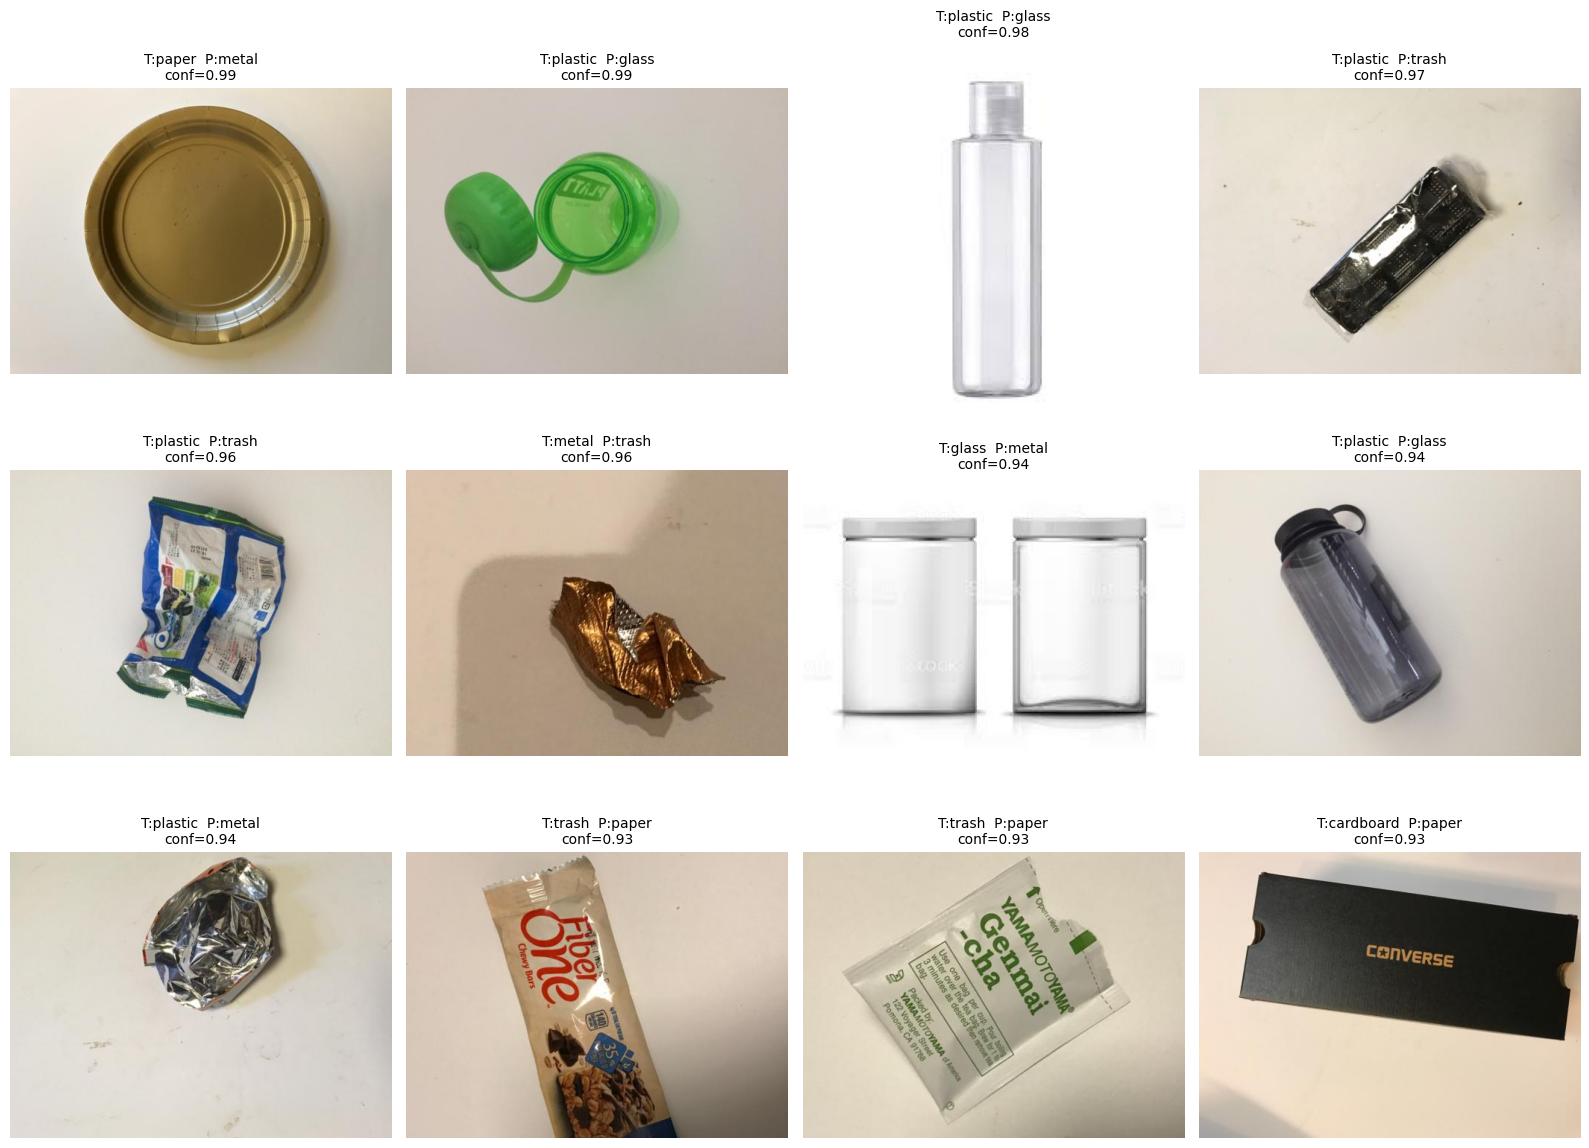


Lowest-confidence correct predictions (potentially ambiguous cases):
  idx= 1235  conf=0.419  class=plastic  file=C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test\test_plastic_007.jpg
  idx= 1188  conf=0.436  class=paper  file=C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test\test_paper_271.jpg
  idx=  744  conf=0.485  class=metal  file=C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test\test_metal_052.jpg
  idx= 1050  conf=0.485  class=paper  file=C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test\test_paper_133.jpg
  idx= 1078  conf=0.509  class=paper  file=C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test\test_paper_161.jpg
  idx= 1387  conf=0.511  class=plastic  file=C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test\test_plastic_159.jpg
  idx= 1338  conf=0.516  class=plastic  file=C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test\test_plastic_110.jpg
 

In [2]:
# ============================================
# Notebook analysis: load model + error analysis
# ============================================

import os
import math
from collections import Counter, defaultdict

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import models, transforms

import pathlib
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# If sklearn is available, great; if not, we'll fall back to manual confusion matrix.
try:
    from sklearn.metrics import confusion_matrix, classification_report
    SKLEARN_OK = True
except Exception:
    SKLEARN_OK = False

# ---- your project imports ----
from config import Config
from data_manager import DataManager
from material_dataset import MaterialDataset


# -----------------------------
# 0) Config + device
# -----------------------------
cfg = Config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -----------------------------
# 1) Pick checkpoint to analyze
# -----------------------------
CKPT_PATH = "../models/polish_best_model.pth"  # <-- change if needed

# -----------------------------
# 2) Build test dataset/loader (choose ONE transform)
#    - Baseline (warped square): Resize((256,256)) then CenterCrop(224)
#    - Or your standard: Resize(256) -> CenterCrop(224)
# Note: batching requires fixed output sizes. The below always outputs 224x224 tensors.
# -----------------------------
transform_test = transforms.Compose([
    transforms.Resize((256, 256)),      # fixed -> stable batching
    transforms.CenterCrop(224),         # model expects 224 input
    transforms.ToTensor(),
    transforms.Normalize(cfg.imagenet_mean, cfg.imagenet_std),
])

# If you want the original imagenet-style instead, use this (batch-safe):
# transform_test = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(cfg.imagenet_mean, cfg.imagenet_std),
# ])

data_manager = DataManager()
data_manager.extract_dataset()

test_files = data_manager.get_test_images_list()
classes = data_manager.get_classes_list()
class_to_idx = data_manager.get_class_index_map()
idx_to_class = {v: k for k, v in class_to_idx.items()}

test_labels = [class_to_idx[data_manager.get_class_from_filename(p)] for p in test_files]

test_dataset = MaterialDataset(
    files=test_files,
    transform=transform_test,
    classes=classes,
    class_to_idx=class_to_idx,
    labels=test_labels
)

# For Windows notebooks, num_workers=0 is the most stable for analysis
test_loader = DataLoader(
    test_dataset,
    batch_size=getattr(cfg, "batch_size_test", 128),
    shuffle=False,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)

print("Test samples:", len(test_dataset))
print("Classes:", classes)

# -----------------------------
# 3) Rebuild model arch (must match training)
# -----------------------------
num_classes = len(classes)
model = models.resnet50(weights=None)  # weights don't matter when loading your checkpoint
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features, num_classes),
)
model = model.to(device)

# -----------------------------
# 4) Load checkpoint
# -----------------------------
ckpt = torch.load(CKPT_PATH, map_location=device)
state_dict = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
model.load_state_dict(state_dict, strict=True)
model.eval()

print("Loaded:", CKPT_PATH)

# -----------------------------
# 5) Run inference (collect preds, probs, paths)
# -----------------------------
@torch.no_grad()
def predict_all(model, loader, device):
    y_true, y_pred, y_prob, paths = [], [], [], []
    for batch_idx, batch in enumerate(loader):
        # MaterialDataset likely returns (img, label) - but if it returns extra fields, handle it.
        if isinstance(batch, (list, tuple)) and len(batch) >= 2:
            imgs, labels = batch[0], batch[1]
        else:
            raise ValueError("Unexpected batch format from DataLoader")

        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        logits = model(imgs)
        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)

        y_true.append(labels.cpu().numpy())
        y_pred.append(preds.cpu().numpy())
        y_prob.append(probs.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    y_prob = np.concatenate(y_prob)

    # paths: if your dataset stores file list at dataset.files, use that
    # (order matches DataLoader order when shuffle=False)
    paths = getattr(loader.dataset, "files", None)
    return y_true, y_pred, y_prob, paths

y_true, y_pred, y_prob, paths = predict_all(model, test_loader, device)

acc = (y_true == y_pred).mean()
print(f"Test accuracy: {acc:.4f}")

# -----------------------------
# 6) Confusion matrix + per-class accuracy
# -----------------------------
def compute_confusion(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes))) if SKLEARN_OK else compute_confusion(y_true, y_pred, num_classes)

per_class_total = cm.sum(axis=1)
per_class_correct = np.diag(cm)
per_class_acc = np.divide(per_class_correct, np.maximum(1, per_class_total))

print("\nPer-class accuracy:")
for i, name in enumerate(classes):
    print(f"  {name:>12s}: {per_class_acc[i]:.4f}  (n={per_class_total[i]})")

if SKLEARN_OK:
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))

# Plot confusion matrix (normalized)
cm_norm = cm.astype(np.float32) / np.maximum(1, cm.sum(axis=1, keepdims=True))
plt.figure(figsize=(7, 6))
plt.imshow(cm_norm, interpolation="nearest")
plt.title("Confusion Matrix (row-normalized)")
plt.colorbar()
ticks = np.arange(num_classes)
plt.xticks(ticks, classes, rotation=45, ha="right")
plt.yticks(ticks, classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# -----------------------------
# 7) Inspect what it got wrong
#    - Show top confusions
#    - Show hardest mistakes (high confidence wrong)
# -----------------------------
wrong = np.where(y_true != y_pred)[0]
print(f"\nWrong predictions: {len(wrong)}/{len(y_true)} ({len(wrong)/len(y_true):.2%})")

# Top confusions by count
pairs = Counter((int(y_true[i]), int(y_pred[i])) for i in wrong)
print("\nTop confusions (true -> pred):")
for (t, p), c in pairs.most_common(10):
    print(f"  {classes[t]} -> {classes[p]}: {c}")

# Hardest mistakes: highest predicted probability for the wrong class
# score = prob of predicted class
wrong_scores = [(i, float(y_prob[i, y_pred[i]])) for i in wrong]
wrong_scores.sort(key=lambda x: x[1], reverse=True)

print("\nTop high-confidence wrong predictions:")
for i, s in wrong_scores[:10]:
    t = int(y_true[i]); p = int(y_pred[i])
    print(f"  idx={i:5d}  conf={s:.3f}  true={classes[t]}  pred={classes[p]}  file={paths[i] if paths else 'N/A'}")

# -----------------------------
# 8) Visualize a grid of mistakes (requires access to original images)
#    We'll re-load images from disk using their file paths.
#    If your dataset paths are relative, adjust base_dir.
# -----------------------------
from PIL import Image

# Try to locate files: if your paths are already absolute, this is fine.
# If they are relative, set BASE_DIR accordingly.
BASE_DIR = None  # e.g. Path(os.getenv("PROJECT_DIR")) or Path("..")

def load_pil(path):
    p = Path(path) if BASE_DIR is None else (Path(BASE_DIR) / path)
    img = Image.open(p).convert("RGB")
    return img

def show_mistakes(n=12):
    if paths is None:
        print("Dataset doesn't expose file paths (dataset.files missing).")
        return
    if len(wrong_scores) == 0:
        print("No mistakes to show 🎉")
        return

    n = min(n, len(wrong_scores))
    cols = 4
    rows = math.ceil(n / cols)

    plt.figure(figsize=(4*cols, 4*rows))
    for k in range(n):
        i, conf = wrong_scores[k]
        t = int(y_true[i]); p = int(y_pred[i])
        img = load_pil(paths[i])

        plt.subplot(rows, cols, k+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"T:{classes[t]}  P:{classes[p]}\nconf={conf:.2f}", fontsize=10)
    plt.tight_layout()
    plt.show()

show_mistakes(n=12)

# -----------------------------
# 9) (Optional) What’s “most ambiguous” even when correct?
#    Look at lowest confidence correct predictions.
# -----------------------------
correct = np.where(y_true == y_pred)[0]
correct_scores = [(i, float(y_prob[i, y_pred[i]])) for i in correct]
correct_scores.sort(key=lambda x: x[1])  # lowest confidence first

print("\nLowest-confidence correct predictions (potentially ambiguous cases):")
for i, s in correct_scores[:10]:
    t = int(y_true[i])
    print(f"  idx={i:5d}  conf={s:.3f}  class={classes[t]}  file={paths[i] if paths else 'N/A'}")
